In [1]:
% matplotlib inline

import numpy as np
import pandas as pd
import json
import sys
import os
import matplotlib
#matplotlib.use('Agg') 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import seaborn as sns
import pdb
#import ipdb
import h5py
import importlib
import pickle
import math

# Add root folder to sys path
sys.path.append("../")

# %pylab inline
# inline doesn't give interactive plots
%matplotlib inline 
# %matplotlib notebook
plt.rcParams['figure.figsize'] = (12.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'Blues'

sns.set()

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Import own modules
# Need to use importlib since module starts with a numerical value.

/home/arjun/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def draw_circle(centre, w, r, direction=1, T = 120, theta_offset = 0):
    c_x = centre[0]
    c_y = centre[1]
    theta_offset = math.radians(theta_offset)
    
    list_of_points = []
    
    old_x = c_x + r * math.sin(theta_offset)
    old_y = c_y - r * math.cos(theta_offset)
    list_of_points.append((old_x, old_y))
    
    for t in range(1, T):
        theta = math.radians(w * t * direction)
        new_x = c_x + r * math.sin(theta + theta_offset)
        new_y = c_y - r * math.cos(theta + theta_offset)
        
        del_x = new_x - old_x # normalize these to unit vectors to get actions
        del_y = new_y - old_y
        
        old_x = new_x
        old_y = new_y
        list_of_points.append((old_x, old_y))
        
    return list_of_points       

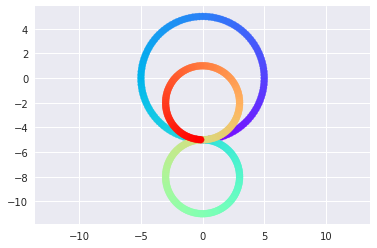

In [3]:
# Meta policy 1

centre1 = (0.0, 0.0)
r1 = 5
w1 = 3
T1 = 120
circle_1 = draw_circle(centre = centre1, w = w1, r = r1, direction=1, T = T1, theta_offset = 0)

centre2 = (0.0, -8.0)
r2 = 3
w2 = 3
T2 = 120
circle_2 = draw_circle(centre = centre2, w = w2, r = r2, direction=-1, T = T2, theta_offset = 180)

centre3 = (0.0, -2.0)
r3 = 3
w3 = 3
T3 = 120
circle_3 = draw_circle(centre = centre3, w = w3, r = r3, direction=1, T = T3, theta_offset = 0)

x_list = []
y_list = []
for i in range(len(circle_1)):
    x_list.append(circle_1[i][0])
    y_list.append(circle_1[i][1])
for i in range(len(circle_2)):
    x_list.append(circle_2[i][0])
    y_list.append(circle_2[i][1])
for i in range(len(circle_3)):
    x_list.append(circle_3[i][0])
    y_list.append(circle_3[i][1])
    
colors = cm.rainbow(np.linspace(0, 1, len(x_list)))
plt.scatter(x_list, y_list, color=colors) 
plt.axis('equal')    
plt.show()

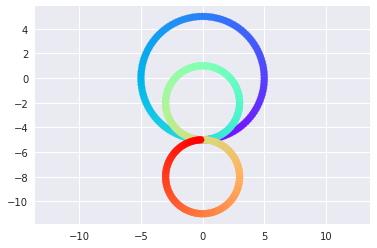

In [4]:
# Meta policy 2

centre1 = (0.0, 0.0)
r1 = 5
w1 = 3
T1 = 120
circle_1 = draw_circle(centre = centre1, w = w1, r = r1, direction=1, T = T1, theta_offset = 0)

centre2 = (0.0, -2.0)
r2 = 3
w2 = 3
T2 = 120
circle_2 = draw_circle(centre = centre2, w = w2, r = r2, direction=1, T = T2, theta_offset = 0)


centre3 = (0.0, -8.0)
r3 = 3
w3 = 3
T3 = 120
circle_3 = draw_circle(centre = centre3, w = w3, r = r3, direction=-1, T = T3, theta_offset = 180)


x_list = []
y_list = []
for i in range(len(circle_1)):
    x_list.append(circle_1[i][0])
    y_list.append(circle_1[i][1])
for i in range(len(circle_2)):
    x_list.append(circle_2[i][0])
    y_list.append(circle_2[i][1])
for i in range(len(circle_3)):
    x_list.append(circle_3[i][0])
    y_list.append(circle_3[i][1])
    
colors = cm.rainbow(np.linspace(0, 1, len(x_list)))
plt.scatter(x_list, y_list, color=colors) 
plt.axis('equal')    
plt.show()